# Local FCI (lFCI) for the high-dimensional Synthetic neural recordings

The dataset is described and analyzed in the paper: 

Altan E, Solla SA, Miller LE, Perreault EJ (2021) Estimating the dimensionality of the manifold underlying multi-electrode neural recordings. *PLoS Comput Biol* **17**(11): e1008591. [https://doi.org/10.1371/journal.pcbi.1008591](https://doi.org/10.1371/journal.pcbi.1008591)

Here we compare our method with the ones proposed in the paper expanding the Fig.5 of the paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from sklearn.neighbors import KernelDensity

In [2]:
from matplotlib import font_manager
font_file = "/usr/share/fonts/avenir_ff/AvenirLTStd-Roman.ttf"
font_file_b = "/usr/share/fonts/avenir_ff/AvenirLTStd-Black.ttf"
font_file_c = "/usr/share/fonts/avenir_ff/AvenirLTStd-Book.ttf"
font_manager.fontManager.addfont(font_file)
font_manager.fontManager.addfont(font_file_b)
font_manager.fontManager.addfont(font_file_c)
my_style = {
    #'font.family': 'DejaVu Serif',
    'font.family': 'Avenir LT Std',
    #'font.sans-serif':  "Avenir",
    'font.size': 10,
    'axes.labelsize': 22,
    'axes.linewidth': 1.5,
    'axes.titlesize': 30,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'image.cmap': 'jet',
}
plt.style.use(my_style)

### Kernel density Function

In [3]:
def id_kernel_density(x, kernel="gaussian", bandwidth=0.3, verbose=False):
    """
    Compute the peak of the kernel density estimate of the given data.

    Parameters
    ----------
    x : array-like
        The data to estimate the kernel density.
    kernel : str, optional
        The kernel to use for the estimation. Default is "gaussian".
    bandwidth : float, optional
        The bandwidth of the kernel. Default is 0.3.
    verbose : bool, optional
        If True, return the x and log density values of the estimated kernel density. Default is False.

    Returns
    -------
    float
        The position of the peak of the kernel density estimate.
    list
        If verbose is True, return a list containing the x and log density values of the estimated kernel density.
    """
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(x.reshape(-1,1))
    x_kde = np.linspace(0,100,3000)
    log_den = kde.score_samples(x_kde.reshape(-1,1))
            
    peak = x_kde[np.argmax(log_den)]

    if verbose:
        return peak, [x_kde, log_den]
    else:
        return peak

###  Data folder

In [4]:
analysis_folder ="HighDimData"
fci_folder = f"{analysis_folder}/ID_results"
figures_dir = f"{analysis_folder}/lFCI_figures"

## Compute lFCI and FCI
run an external script that computes lFCI and FCI

In [5]:
compute = False
if compute:
    from lFCI_analysis_HighDimData import compute_lfci_high_dim_data
    compute_lfci_high_dim_data()

## Linear Embedding

In [6]:
embedding_lin = "lin"
delta_thr = 3
gof_thr = 0.02

### D6

In [7]:
file_name = f"lfci_6d_{embedding_lin}.h5"

In [8]:
with h5py.File(f"{fci_folder}/{file_name}","r") as f:
    print(f.keys())
    deltas_d6_ll = f["deltas"][:]
    ids_d6_ll = f["local_ids"][:][:,:,1]
    gof_d6_ll = f["local_ids"][:,:,2]
    k_d6_ll = f["local_ids"][:][:,:,0]

<KeysViewHDF5 ['centers', 'deltas', 'local_ids', 'neighbor_indices', 'neighborhoods', 'selected_distances']>


In [9]:
deltas_flat_d6_ll = deltas_d6_ll.flatten()
ids_flat_d6_ll = ids_d6_ll.flatten()
k_flat_d6_ll = k_d6_ll.flatten()
gof_flat_d6_ll = gof_d6_ll.flatten()

#### ID *vs* GoF

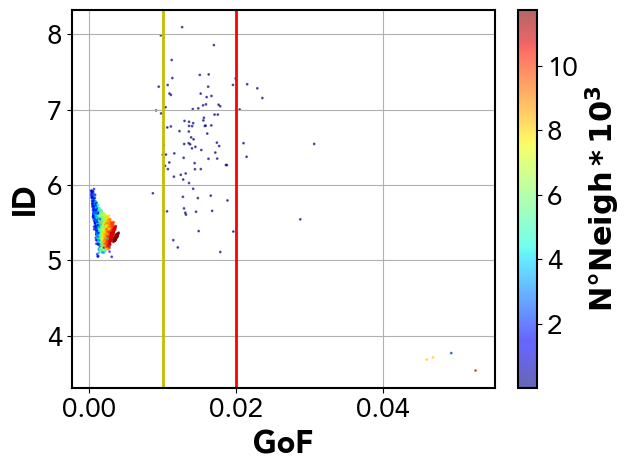

In [10]:
fig, ax = plt.subplots(tight_layout=True)
a = ax.scatter(gof_flat_d6_ll, ids_flat_d6_ll, c=k_flat_d6_ll/1000, s=1, cmap="jet", alpha = 0.6) 
plt.colorbar(a,fraction=0.05, label=r"$\mathbf{N° Neigh* 10^3}$")
ax.set_xlabel("GoF", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")                
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
#ax.set_xlim(0,0.05)
#ax.set_ylim(2,3.5)
ax.grid()
#plt.savefig(f"{figures_dir}/IDvsGoF_d6_ll.pdf")
plt.show()

#### ID *vs* #Neighbors 

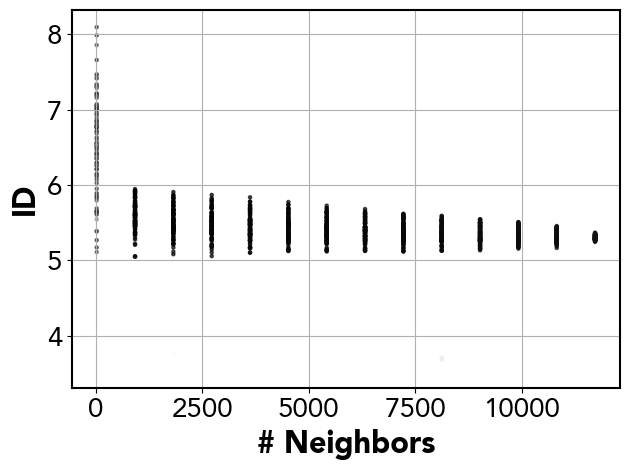

In [11]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_flat_d6_ll, ids_flat_d6_ll, c=gof_flat_d6_ll,vmin=0,vmax=0.05, cmap="gray", alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figures_dir}/IDvsNeighbors_d6_ll.pdf")
plt.show()

In [12]:
cond_d6_ll = (gof_flat_d6_ll<gof_thr)&(deltas_flat_d6_ll<delta_thr)
idx_good_d6_ll = np.where(cond_d6_ll)
idx_bad_d6_ll = np.where(~cond_d6_ll)

In [13]:
k_d6_ll_good = k_flat_d6_ll[idx_good_d6_ll]
ids_d6_ll_good = ids_flat_d6_ll[idx_good_d6_ll]
k_d6_ll_bad = k_flat_d6_ll[idx_bad_d6_ll]
ids_d6_ll_bad = ids_flat_d6_ll[idx_bad_d6_ll]

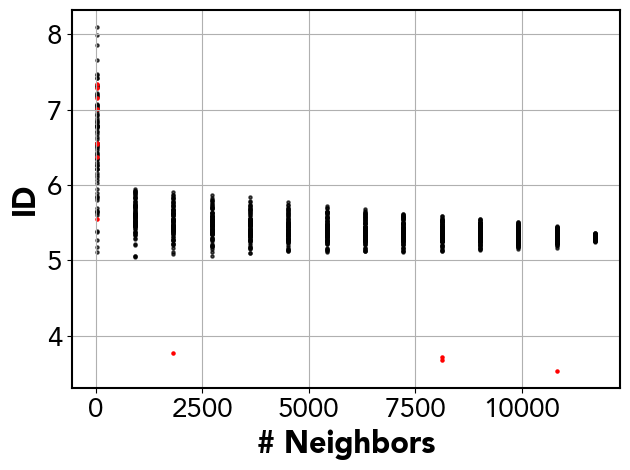

In [14]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_d6_ll_good,ids_d6_ll_good, c="k",  alpha = 0.7,s=5)
ax.scatter(k_d6_ll_bad,ids_d6_ll_bad, c="r", s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
plt.savefig(f"{figures_dir}/IDvsNeighbors_d6_ll_good_bad.pdf")
plt.show()

#### Histogram

In [15]:
hist_d6_ll_g, bin_edges_d6_ll_g = np.histogram(ids_d6_ll_good,range=(4,7), bins=30,density=True)

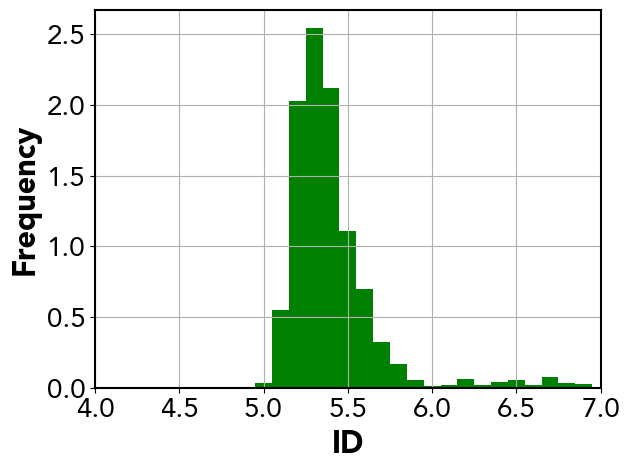

In [16]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d6_ll_g[:-1], hist_d6_ll_g, width=np.diff(bin_edges_d6_ll_g), color="green")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(4,7)
ax.grid()
plt.savefig(f"{figures_dir}/IDdistribution_d6_ll_good.pdf")
plt.show()

In [17]:
id_kde_d6_ll, log_den_d6_ll = id_kernel_density(ids_d6_ll_good, bandwidth=0.1,verbose=True)
print(f"ID kde = {id_kde_d6_ll:.2f}")

ID kde = 5.37


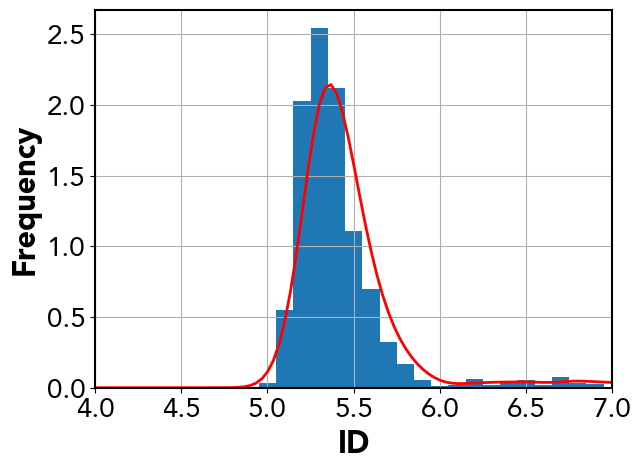

In [18]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d6_ll_g[:-1], hist_d6_ll_g, width=np.diff(bin_edges_d6_ll_g))
ax.plot(log_den_d6_ll[0], np.exp(log_den_d6_ll[1]), color="r")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(4,7)
ax.grid()
plt.show()

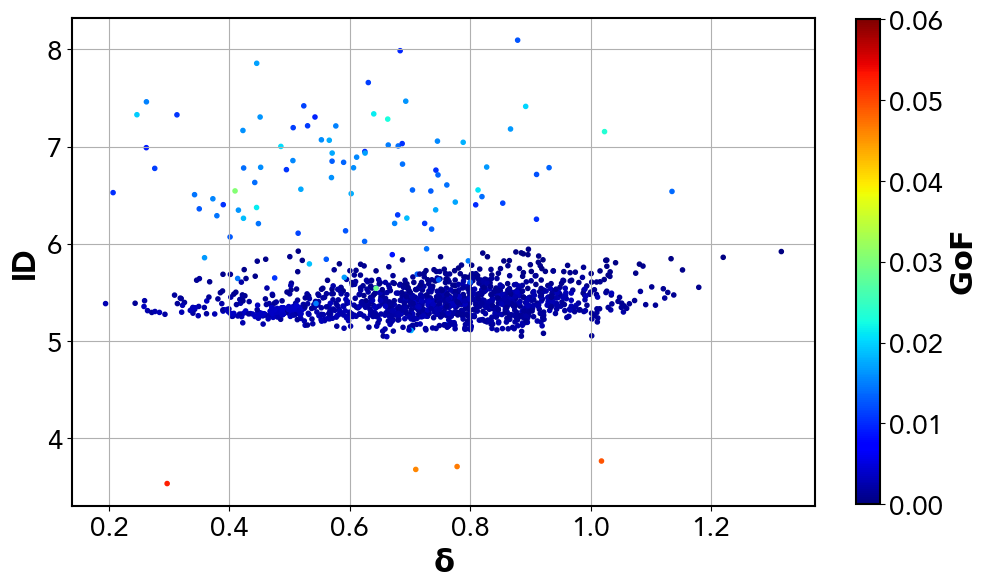

In [19]:
fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
AA = ax.scatter(deltas_flat_d6_ll, ids_flat_d6_ll, c=gof_flat_d6_ll,vmin=0,vmax=0.06, cmap="jet", s=9)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_xlabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.show()

### D20

In [20]:
file_name = f"lfci_20d_{embedding_lin}.h5"

In [21]:
with h5py.File(f"{fci_folder}/{file_name}","r") as f:
    print(f.keys())
    deltas_d20_ll = f["deltas"][:]
    ids_d20_ll = f["local_ids"][:][:,:,1]
    gof_d20_ll = f["local_ids"][:,:,2]
    k_d20_ll = f["local_ids"][:][:,:,0]

<KeysViewHDF5 ['centers', 'deltas', 'local_ids', 'neighbor_indices', 'neighborhoods', 'selected_distances']>


In [22]:
deltas_flat_d20_ll = deltas_d20_ll.flatten()
ids_flat_d20_ll = ids_d20_ll.flatten()
k_flat_d20_ll = k_d20_ll.flatten()
gof_flat_d20_ll = gof_d20_ll.flatten()

#### ID *vs* GoF

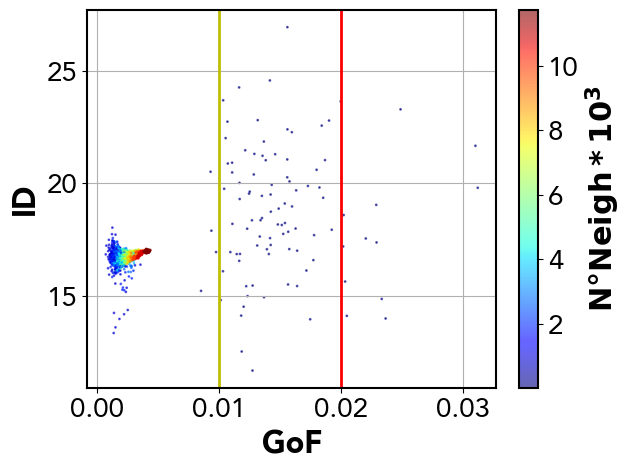

In [23]:
fig, ax = plt.subplots(tight_layout=True)
a = ax.scatter(gof_flat_d20_ll, ids_flat_d20_ll, c=k_flat_d20_ll/1000, s=1, cmap="jet", alpha = 0.6) 
plt.colorbar(a,fraction=0.05, label=r"$\mathbf{N° Neigh* 10^3}$")
ax.set_xlabel("GoF", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")                
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
#ax.set_xlim(0,0.05)
#ax.set_ylim(2,3.5)
ax.grid()
#plt.savefig(f"{figures_dir}/IDvsGoF_d20_ll.pdf")
plt.show()

#### ID *vs* #Neighbors 

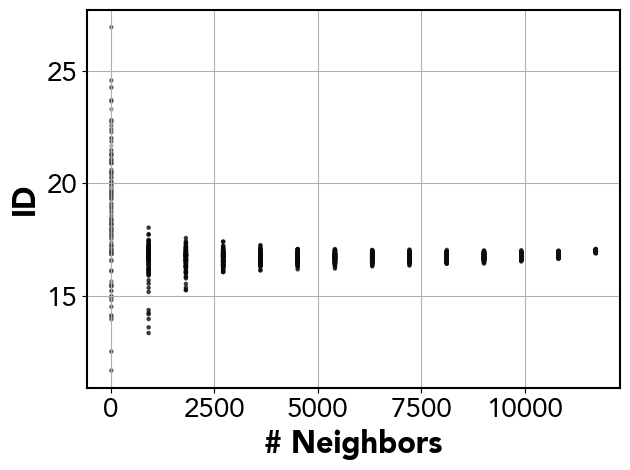

In [24]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_flat_d20_ll, ids_flat_d20_ll, c=gof_flat_d20_ll,vmin=0,vmax=0.05, cmap="gray", alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figures_dir}/IDvsNeighbors_d20_ll.pdf")
plt.show()

In [25]:
cond_d20_ll = (gof_flat_d20_ll<gof_thr)&(deltas_flat_d20_ll<delta_thr)
idx_good_d20_ll = np.where(cond_d20_ll)
idx_bad_d20_ll = np.where(~cond_d20_ll)

In [26]:
k_d20_ll_good = k_flat_d20_ll[idx_good_d20_ll]
ids_d20_ll_good = ids_flat_d20_ll[idx_good_d20_ll]
k_d20_ll_bad = k_flat_d20_ll[idx_bad_d20_ll]
ids_d20_ll_bad = ids_flat_d20_ll[idx_bad_d20_ll]

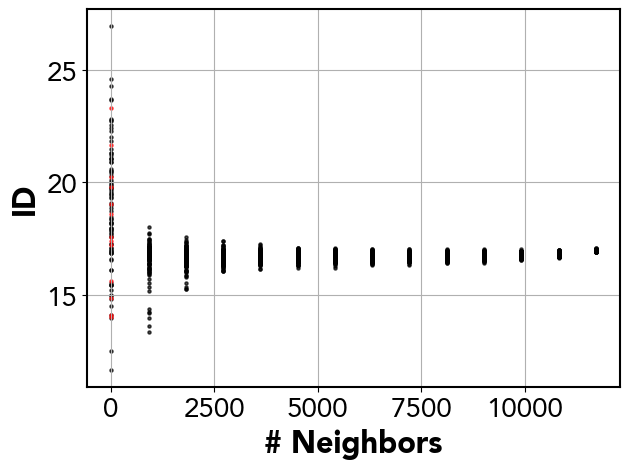

In [27]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_d20_ll_good,ids_d20_ll_good, c="k",  alpha = 0.7,s=5)
ax.scatter(k_d20_ll_bad,ids_d20_ll_bad, c="r",  alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
plt.savefig(f"{figures_dir}/IDvsNeighbors_d20_ll_good_bad.pdf")
plt.show()

#### Histogram

In [28]:
hist_d20_ll_g, bin_edges_d20_ll_g = np.histogram(ids_d20_ll_good,range=(15,25), bins=40,density=True)

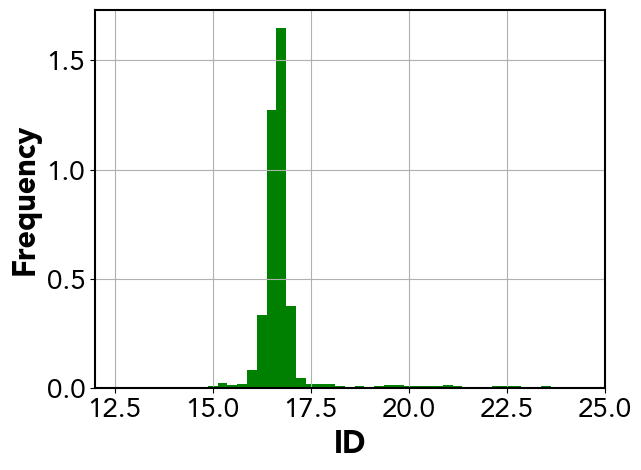

In [29]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d20_ll_g[:-1], hist_d20_ll_g, width=np.diff(bin_edges_d20_ll_g), color="green")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(12,25)
ax.grid()
plt.savefig(f"{figures_dir}/IDdistribution_d20_ll_good.pdf")
plt.show()

In [30]:
id_kde_d20_ll, log_den_d20_ll = id_kernel_density(ids_d20_ll_good, bandwidth=0.1,verbose=True)
print(f"ID kde = {id_kde_d20_ll:.2f}")

ID kde = 16.81


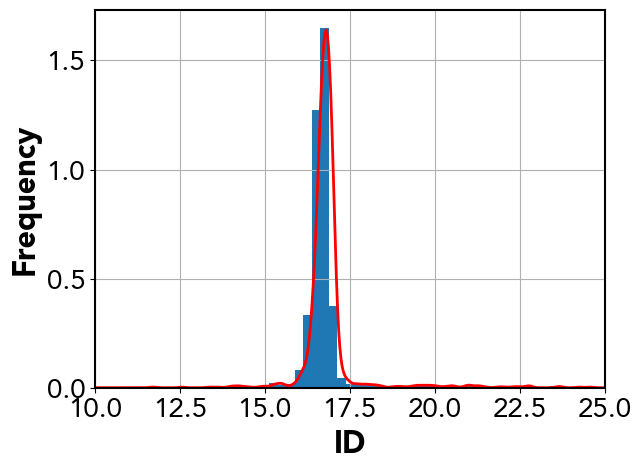

In [31]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d20_ll_g[:-1], hist_d20_ll_g, width=np.diff(bin_edges_d20_ll_g))
ax.plot(log_den_d20_ll[0], np.exp(log_den_d20_ll[1]), color="r")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(10,25)
ax.grid()
plt.show()

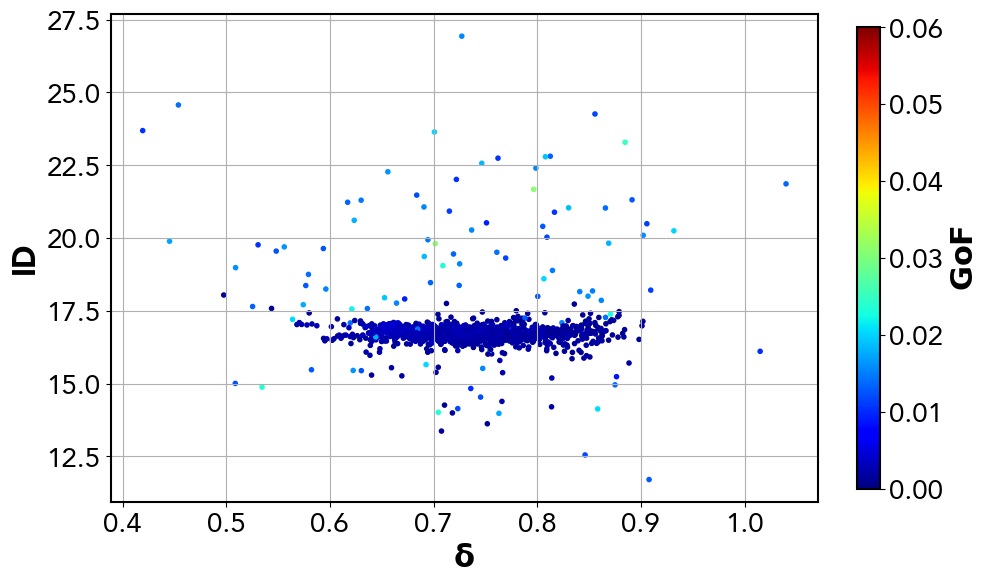

In [32]:
fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
AA = ax.scatter(deltas_flat_d20_ll, ids_flat_d20_ll, c=gof_flat_d20_ll,vmin=0,vmax=0.06, cmap="jet", s=9)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_xlabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.show()

### D40

In [33]:
file_name = f"lfci_40d_{embedding_lin}.h5"

In [34]:
with h5py.File(f"{fci_folder}/{file_name}","r") as f:
    print(f.keys())
    deltas_d40_ll = f["deltas"][:]
    ids_d40_ll = f["local_ids"][:][:,:,1]
    gof_d40_ll = f["local_ids"][:,:,2]
    k_d40_ll = f["local_ids"][:][:,:,0]

<KeysViewHDF5 ['centers', 'deltas', 'local_ids', 'neighbor_indices', 'neighborhoods', 'selected_distances']>


In [35]:
deltas_flat_d40_ll = deltas_d40_ll.flatten()
ids_flat_d40_ll = ids_d40_ll.flatten()
k_flat_d40_ll = k_d40_ll.flatten()
gof_flat_d40_ll = gof_d40_ll.flatten()

#### ID *vs* GoF

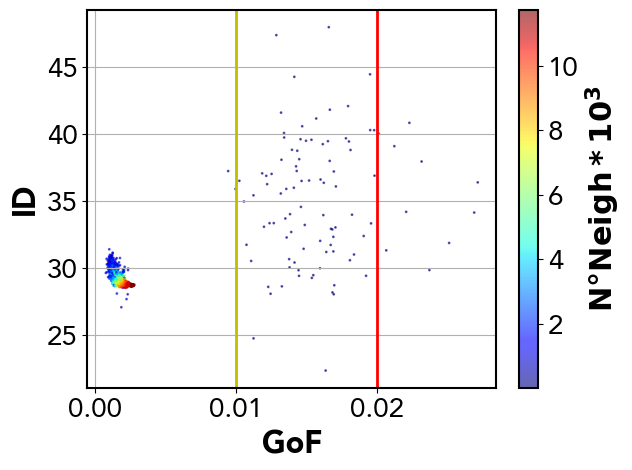

In [36]:
fig, ax = plt.subplots(tight_layout=True)
a = ax.scatter(gof_flat_d40_ll, ids_flat_d40_ll, c=k_flat_d40_ll/1000, s=1, cmap="jet", alpha = 0.6) 
plt.colorbar(a,fraction=0.05, label=r"$\mathbf{N° Neigh* 10^3}$")
ax.set_xlabel("GoF", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")                
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
#ax.set_xlim(0,0.05)
#ax.set_ylim(2,3.5)
ax.grid()
#plt.savefig(f"{figures_dir}/IDvsGoF_d40_ll.pdf")
plt.show()

#### ID *vs* #Neighbors 

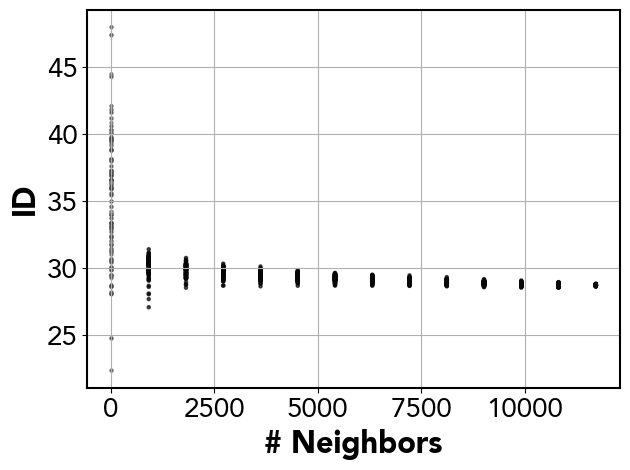

In [37]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_flat_d40_ll, ids_flat_d40_ll, c=gof_flat_d40_ll,vmin=0,vmax=0.05, cmap="gray", alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figures_dir}/IDvsNeighbors_d40_ll.pdf")
plt.show()

In [38]:
cond_d40_ll = (gof_flat_d40_ll<gof_thr)&(deltas_flat_d40_ll<delta_thr)
idx_good_d40_ll = np.where(cond_d40_ll)
idx_bad_d40_ll = np.where(~cond_d40_ll)

In [39]:
k_d40_ll_good = k_flat_d40_ll[idx_good_d40_ll]
ids_d40_ll_good = ids_flat_d40_ll[idx_good_d40_ll]
k_d40_ll_bad = k_flat_d40_ll[idx_bad_d40_ll]
ids_d40_ll_bad = ids_flat_d40_ll[idx_bad_d40_ll]

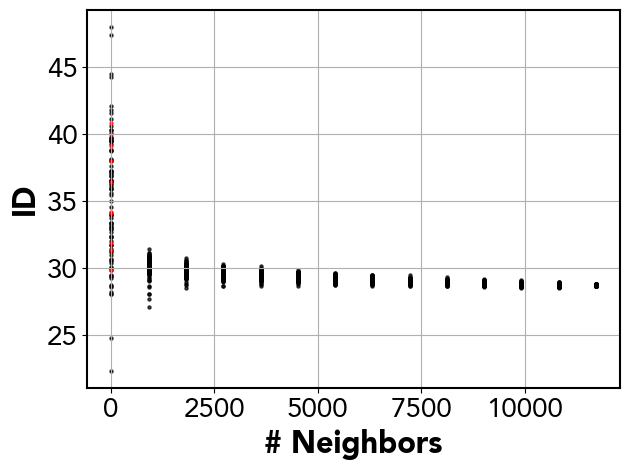

In [40]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_d40_ll_good,ids_d40_ll_good, c="k",  alpha = 0.7,s=5)
ax.scatter(k_d40_ll_bad,ids_d40_ll_bad, c="r",  alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
plt.savefig(f"{figures_dir}/IDvsNeighbors_d40_ll_good_bad.pdf")
plt.show()

#### Histogram

In [41]:
hist_d40_ll_g, bin_edges_d40_ll_g = np.histogram(ids_d40_ll_good,range=(20,40), bins=40,density=True)

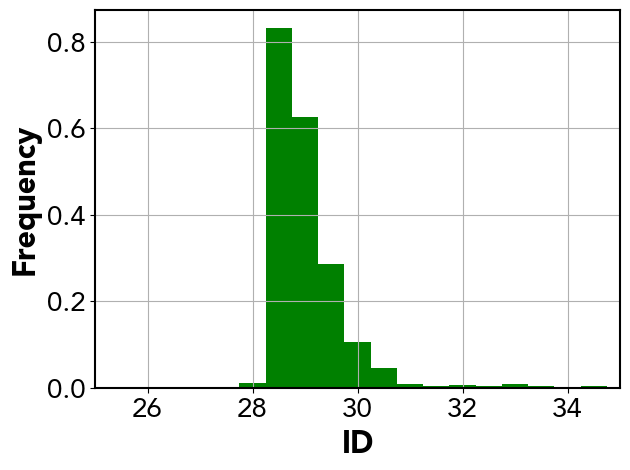

In [42]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d40_ll_g[:-1], hist_d40_ll_g, width=np.diff(bin_edges_d40_ll_g), color="green")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(25,35)
ax.grid()
plt.savefig(f"{figures_dir}/IDdistribution_d40_ll_good.pdf")
plt.show()

In [43]:
id_kde_d40_ll, log_den_d40_ll = id_kernel_density(ids_d40_ll_good, bandwidth=0.1,verbose=True)
print(f"ID kde = {id_kde_d40_ll:.2f}")

ID kde = 28.74


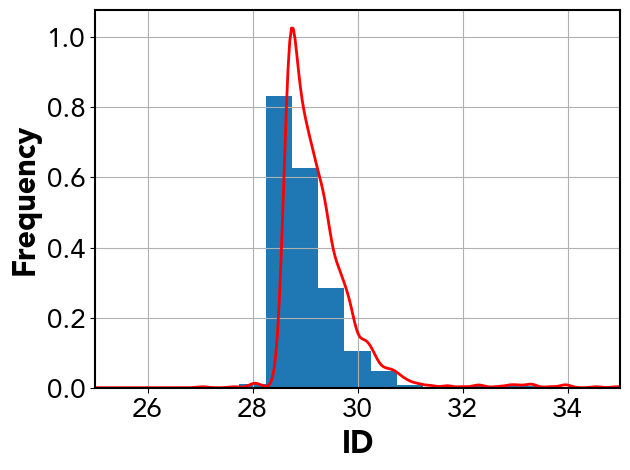

In [44]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d40_ll_g[:-1], hist_d40_ll_g, width=np.diff(bin_edges_d40_ll_g))
ax.plot(log_den_d40_ll[0], np.exp(log_den_d40_ll[1]), color="r")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(25,35)
ax.grid()
plt.show()

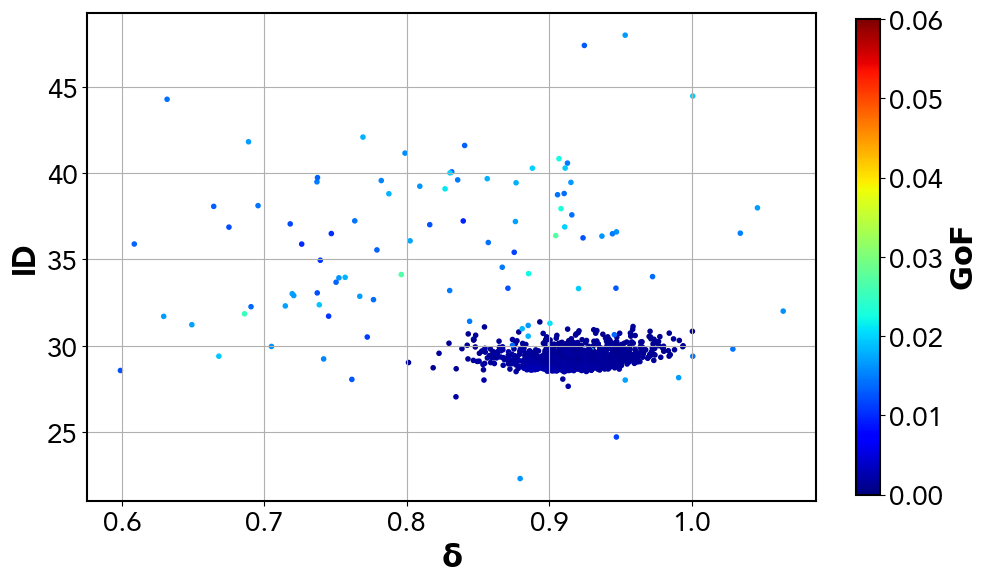

In [45]:
fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
AA = ax.scatter(deltas_flat_d40_ll, ids_flat_d40_ll, c=gof_flat_d40_ll,vmin=0,vmax=0.06, cmap="jet", s=9)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_xlabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.show()

## Exponential Embedding

In [46]:
embedding_exp = "exp"
delta_thr = 3
gof_thr = 0.02

### D6

In [47]:
file_name = f"lfci_6d_{embedding_exp}.h5"

In [48]:
with h5py.File(f"{fci_folder}/{file_name}","r") as f:
    print(f.keys())
    deltas_d6_el = f["deltas"][:]
    ids_d6_el = f["local_ids"][:][:,:,1]
    gof_d6_el = f["local_ids"][:,:,2]
    k_d6_el = f["local_ids"][:][:,:,0]

<KeysViewHDF5 ['centers', 'deltas', 'local_ids', 'neighbor_indices', 'neighborhoods', 'selected_distances']>


In [49]:
deltas_flat_d6_el = deltas_d6_el.flatten()
ids_flat_d6_el = ids_d6_el.flatten()
k_flat_d6_el = k_d6_el.flatten()
gof_flat_d6_el = gof_d6_el.flatten()

#### ID *vs* GoF

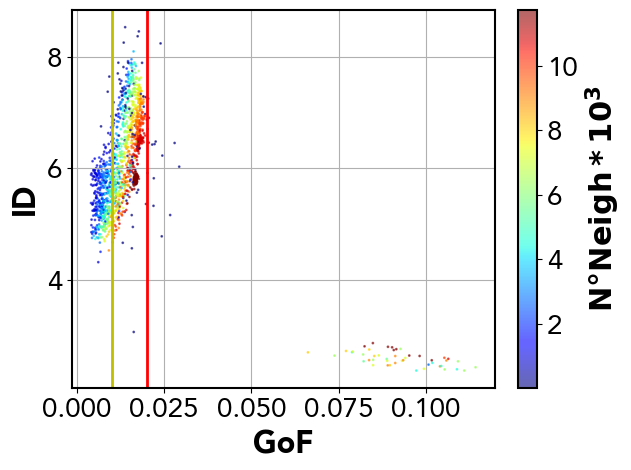

In [50]:
fig, ax = plt.subplots(tight_layout=True)
a = ax.scatter(gof_flat_d6_el, ids_flat_d6_el, c=k_flat_d6_el/1000, s=1, cmap="jet", alpha = 0.6) 
plt.colorbar(a,fraction=0.05, label=r"$\mathbf{N° Neigh* 10^3}$")
ax.set_xlabel("GoF", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")                
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
#ax.set_xlim(0,0.05)
#ax.set_ylim(2,3.5)
ax.grid()
#plt.savefig(f"{figures_dir}/IDvsGoF_d6_el.pdf")
plt.show()

#### ID *vs* #Neighbors 

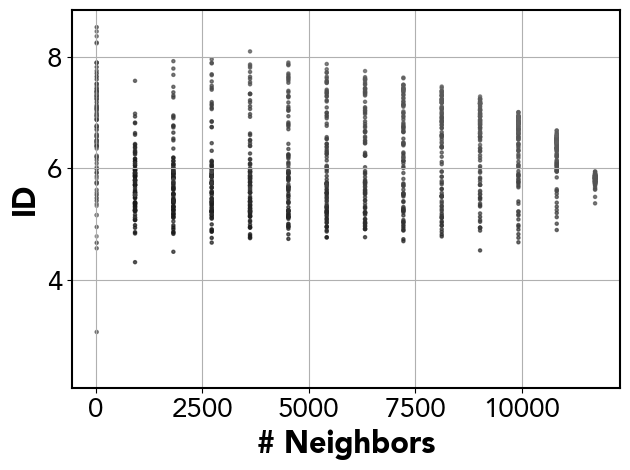

In [51]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_flat_d6_el, ids_flat_d6_el, c=gof_flat_d6_el,vmin=0,vmax=0.05, cmap="gray", alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figures_dir}/IDvsNeighbors_d6_el.pdf")
plt.show()

In [52]:
cond_d6_el = (gof_flat_d6_el<gof_thr)&(deltas_flat_d6_el<delta_thr)
idx_good_d6_el = np.where(cond_d6_el)
idx_bad_d6_el = np.where(~cond_d6_el)

In [53]:
k_d6_el_good = k_flat_d6_el[idx_good_d6_el]
ids_d6_el_good = ids_flat_d6_el[idx_good_d6_el]
k_d6_el_bad = k_flat_d6_el[idx_bad_d6_el]
ids_d6_el_bad = ids_flat_d6_el[idx_bad_d6_el]

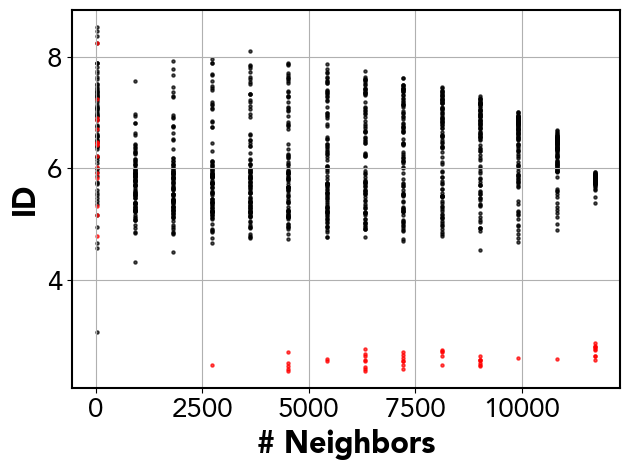

In [54]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_d6_el_good,ids_d6_el_good, c="k",  alpha = 0.7,s=5)
ax.scatter(k_d6_el_bad,ids_d6_el_bad, c="r",  alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
plt.savefig(f"{figures_dir}/IDvsNeighbors_d6_el_good_bad.pdf")
plt.show()

#### Histogram

In [55]:
hist_d6_el_g, bin_edges_d6_el_g = np.histogram(ids_d6_el_good,range=(3,10), bins=40,density=True)

In [56]:
hist_d6_el_all, bin_edges_d6_el_all = np.histogram(ids_flat_d6_el,range=(3,10), bins=40,density=True)

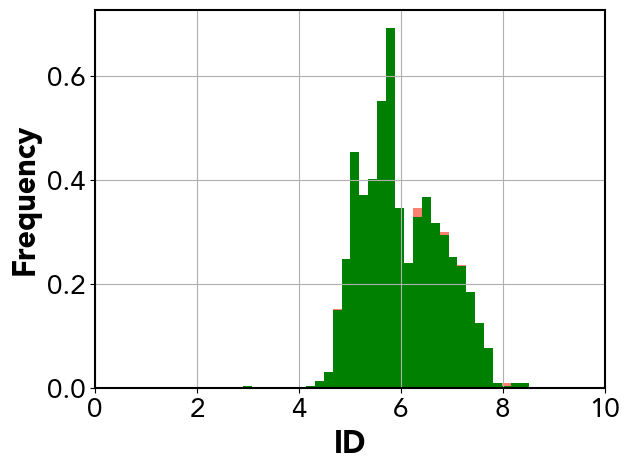

In [57]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d6_el_all[:-1], hist_d6_el_all, width=np.diff(bin_edges_d6_el_all), color="salmon")
plt.bar(bin_edges_d6_el_g[:-1], hist_d6_el_g, width=np.diff(bin_edges_d6_el_g),color="green")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(0,10)
ax.grid()
plt.savefig(f"{figures_dir}/IDdistribution_d6_el_all_good.pdf")
plt.show()

In [58]:
id_kde_d6_el, log_den_d6_el = id_kernel_density(ids_d6_el_good, bandwidth=0.3,verbose=True)
print(f"ID kde = {id_kde_d6_el:.2f}")

ID kde = 5.74


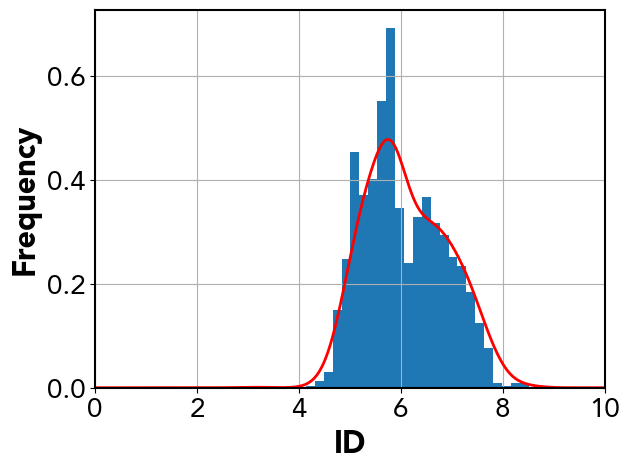

In [59]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d6_el_g[:-1], hist_d6_el_g, width=np.diff(bin_edges_d6_el_g))
ax.plot(log_den_d6_el[0], np.exp(log_den_d6_el[1]), color="r")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(0,10)
ax.grid()
plt.show()

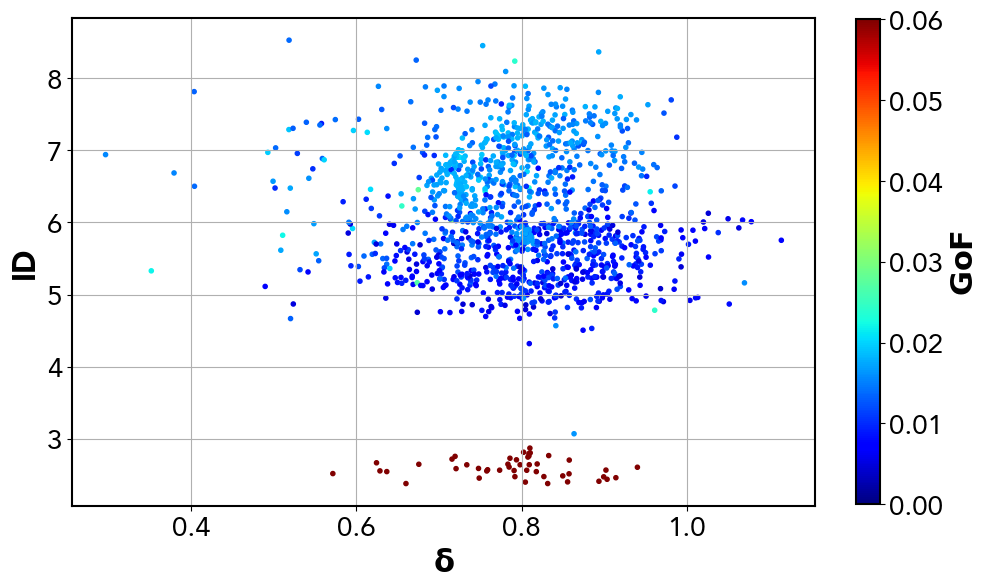

In [60]:
fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
AA = ax.scatter(deltas_flat_d6_el, ids_flat_d6_el, c=gof_flat_d6_el,vmin=0,vmax=0.06, cmap="jet", s=9)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_xlabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.show()

### D20

In [61]:
file_name = f"lfci_20d_{embedding_exp}.h5"

In [62]:
with h5py.File(f"{fci_folder}/{file_name}","r") as f:
    print(f.keys())
    deltas_d20_el = f["deltas"][:]
    ids_d20_el = f["local_ids"][:][:,:,1]
    gof_d20_el = f["local_ids"][:,:,2]
    k_d20_el = f["local_ids"][:][:,:,0]

<KeysViewHDF5 ['centers', 'deltas', 'local_ids', 'neighbor_indices', 'neighborhoods', 'selected_distances']>


In [63]:
deltas_flat_d20_el = deltas_d20_el.flatten()
ids_flat_d20_el = ids_d20_el.flatten()
k_flat_d20_el = k_d20_el.flatten()
gof_flat_d20_el = gof_d20_el.flatten()

#### ID *vs* GoF

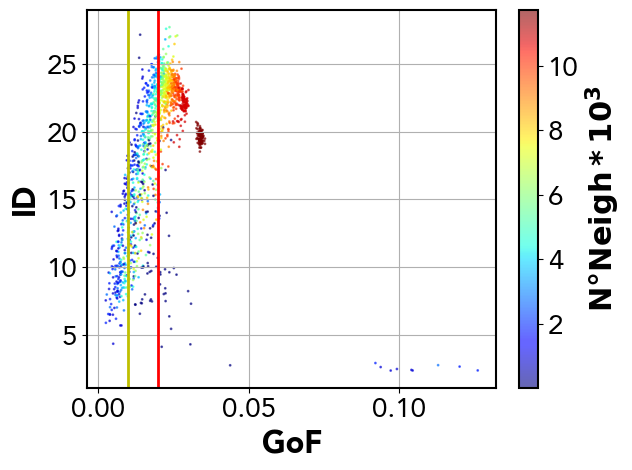

In [64]:
fig, ax = plt.subplots(tight_layout=True)
a = ax.scatter(gof_flat_d20_el, ids_flat_d20_el, c=k_flat_d20_el/1000, s=1, cmap="jet", alpha = 0.6) 
plt.colorbar(a,fraction=0.05, label=r"$\mathbf{N° Neigh* 10^3}$")
ax.set_xlabel("GoF", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")                
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
#ax.set_xlim(0,0.05)
#ax.set_ylim(2,3.5)
ax.grid()
#plt.savefig(f"{figures_dir}/IDvsGoF_d20_el.pdf")
plt.show()

#### ID *vs* #Neighbors 

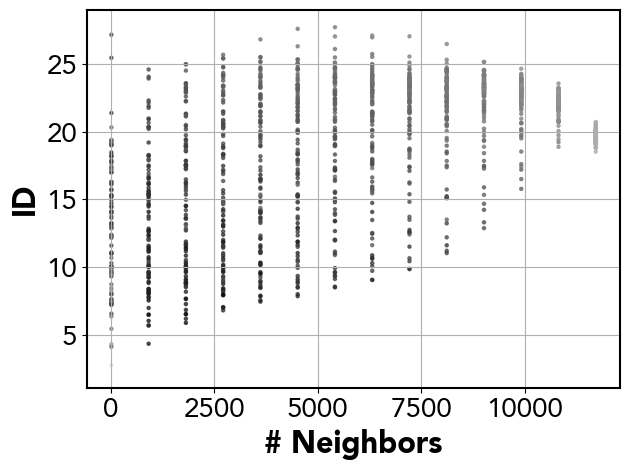

In [65]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_flat_d20_el, ids_flat_d20_el, c=gof_flat_d20_el,vmin=0,vmax=0.05, cmap="gray", alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figures_dir}/IDvsNeighbors_d20_el.pdf")
plt.show()

In [66]:
cond_d20_el = (gof_flat_d20_el<gof_thr)&(deltas_flat_d20_el<delta_thr)
idx_good_d20_el = np.where(cond_d20_el)
idx_bad_d20_el = np.where(~cond_d20_el)

In [67]:
k_d20_el_good = k_flat_d20_el[idx_good_d20_el]
ids_d20_el_good = ids_flat_d20_el[idx_good_d20_el]
k_d20_el_bad = k_flat_d20_el[idx_bad_d20_el]
ids_d20_el_bad = ids_flat_d20_el[idx_bad_d20_el]

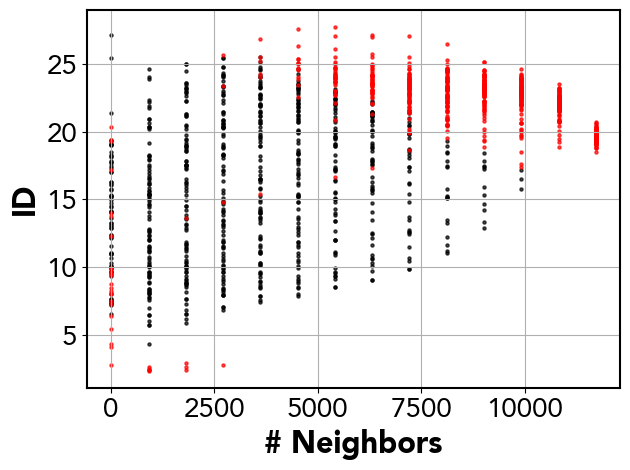

In [68]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_d20_el_good,ids_d20_el_good, c="k",  alpha = 0.7,s=5)
ax.scatter(k_d20_el_bad,ids_d20_el_bad, c="r",  alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
plt.savefig(f"{figures_dir}/IDvsNeighbors_d20_el_good_bad.pdf")
plt.show()

#### Histogram

In [69]:
hist_d20_el_g, bin_edges_d20_el_g = np.histogram(ids_d20_el_good,range=(0,30), bins=60,density=True)

In [70]:
hist_d20_el_all, bin_edges_d20_el_all = np.histogram(ids_flat_d20_el,range=(0,30), bins=60,density=True)

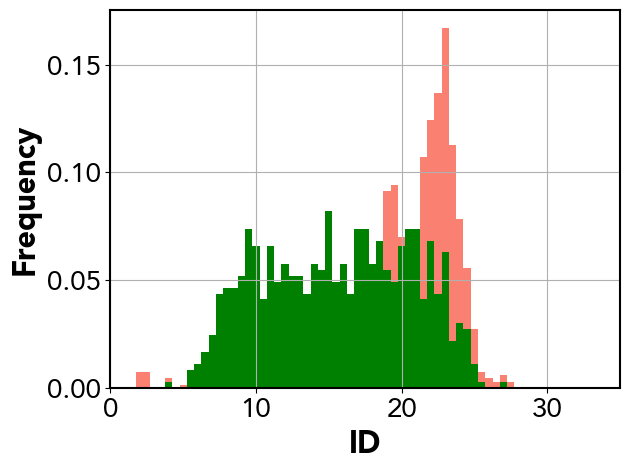

In [71]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d20_el_all[:-1], hist_d20_el_all, width=np.diff(bin_edges_d20_el_all), color="salmon")
plt.bar(bin_edges_d20_el_g[:-1], hist_d20_el_g, width=np.diff(bin_edges_d20_el_g),color="green")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(0,35)
ax.grid()
plt.savefig(f"{figures_dir}/IDdistribution_d20_el_all_good.pdf")
plt.show()

In [72]:
id_kde_d20_el, log_den_d20_el = id_kernel_density(ids_d20_el_good, bandwidth=0.3,verbose=True)
print(f"ID kde = {id_kde_d20_el:.2f}")

ID kde = 17.47


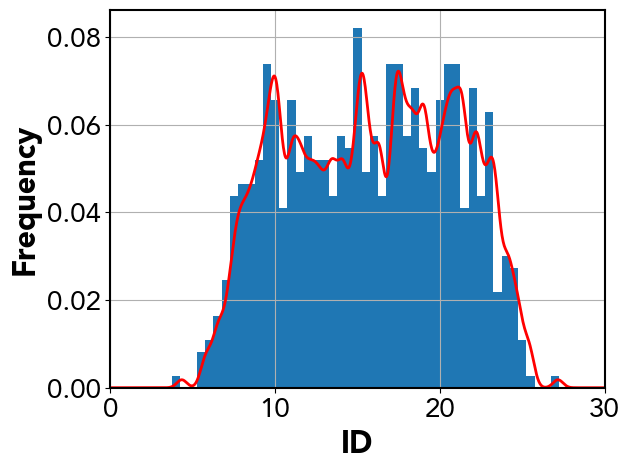

In [73]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d20_el_g[:-1], hist_d20_el_g, width=np.diff(bin_edges_d20_el_g))
ax.plot(log_den_d20_el[0], np.exp(log_den_d20_el[1]), color="r")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(0,30)
ax.grid()
plt.show()

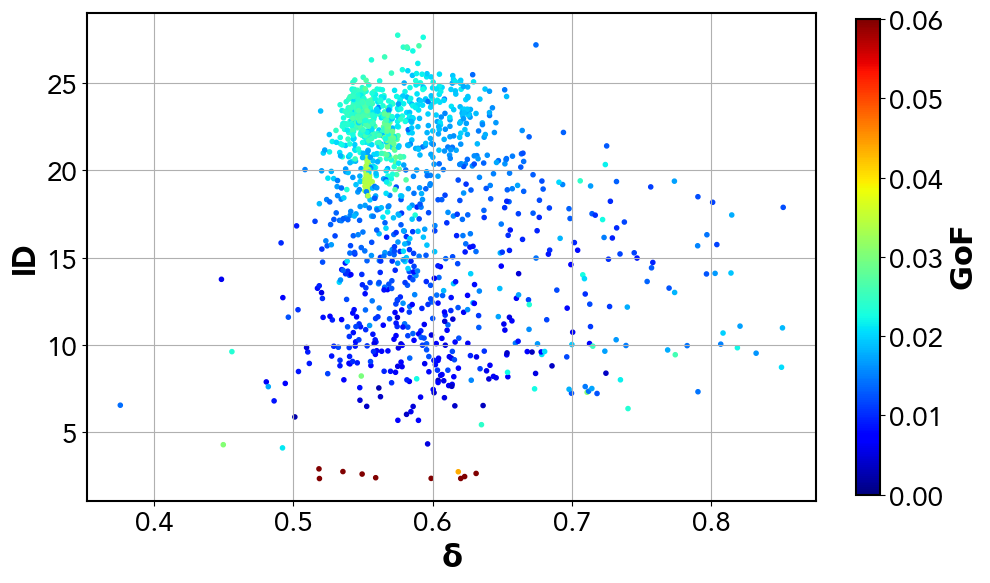

In [74]:
fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
AA = ax.scatter(deltas_flat_d20_el, ids_flat_d20_el, c=gof_flat_d20_el,vmin=0,vmax=0.06, cmap="jet", s=9)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_xlabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.show()

### D40

In [75]:
file_name = f"lfci_40d_{embedding_exp}.h5"

In [76]:
with h5py.File(f"{fci_folder}/{file_name}","r") as f:
    print(f.keys())
    deltas_d40_el = f["deltas"][:]
    ids_d40_el = f["local_ids"][:][:,:,1]
    gof_d40_el = f["local_ids"][:,:,2]
    k_d40_el = f["local_ids"][:][:,:,0]

<KeysViewHDF5 ['centers', 'deltas', 'local_ids', 'neighbor_indices', 'neighborhoods', 'selected_distances']>


In [77]:
deltas_flat_d40_el = deltas_d40_el.flatten()
ids_flat_d40_el = ids_d40_el.flatten()
k_flat_d40_el = k_d40_el.flatten()
gof_flat_d40_el = gof_d40_el.flatten()

#### ID *vs* GoF

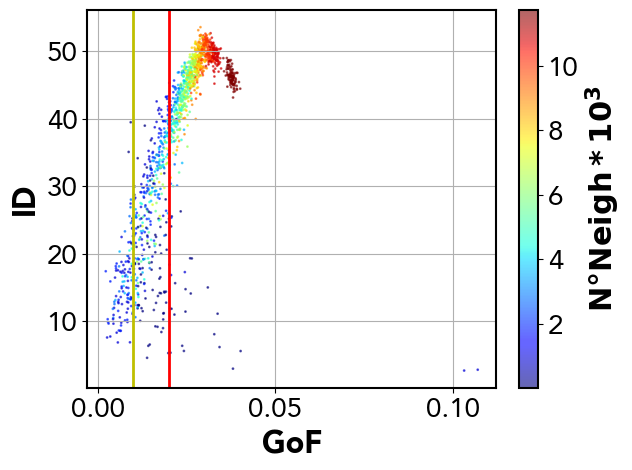

In [78]:
fig, ax = plt.subplots(tight_layout=True)
a = ax.scatter(gof_flat_d40_el, ids_flat_d40_el, c=k_flat_d40_el/1000, s=1, cmap="jet", alpha = 0.6) 
plt.colorbar(a,fraction=0.05, label=r"$\mathbf{N° Neigh* 10^3}$")
ax.set_xlabel("GoF", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")                
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
#ax.set_xlim(0,0.05)
#ax.set_ylim(2,3.5)
ax.grid()
#plt.savefig(f"{figures_dir}/IDvsGoF_d40_el.pdf")
plt.show()

#### ID *vs* #Neighbors 

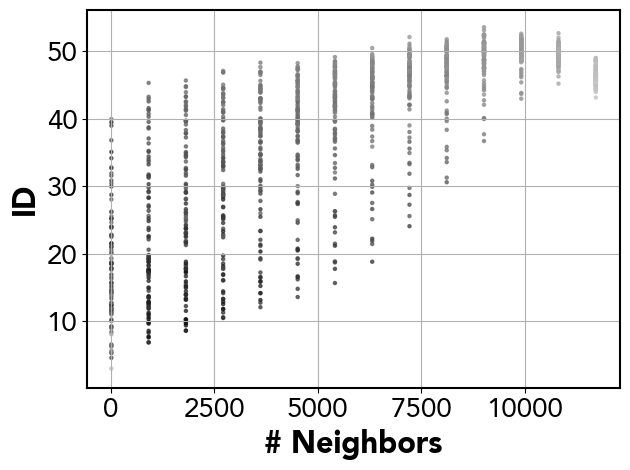

In [79]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_flat_d40_el, ids_flat_d40_el, c=gof_flat_d40_el,vmin=0,vmax=0.05, cmap="gray", alpha = 0.7,s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figures_dir}/IDvsNeighbors_d40_el.pdf")
plt.show()

In [80]:
cond_d40_el = (gof_flat_d40_el<gof_thr)&(deltas_flat_d40_el<delta_thr)
idx_good_d40_el = np.where(cond_d40_el)
idx_bad_d40_el = np.where(~cond_d40_el)

In [81]:
k_d40_el_good = k_flat_d40_el[idx_good_d40_el]
ids_d40_el_good = ids_flat_d40_el[idx_good_d40_el]
k_d40_el_bad = k_flat_d40_el[idx_bad_d40_el]
ids_d40_el_bad = ids_flat_d40_el[idx_bad_d40_el]

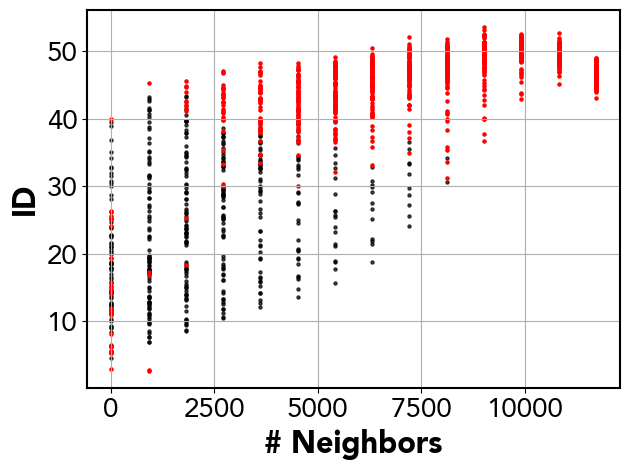

In [82]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_d40_el_good,ids_d40_el_good, c="k",  alpha = 0.7,s=5)
ax.scatter(k_d40_el_bad,ids_d40_el_bad, c="r", s=5)
ax.grid()
#ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
plt.savefig(f"{figures_dir}/IDvsNeighbors_d40_el_good_bad.pdf")
plt.show()

#### Histogram

In [83]:
hist_d40_el_g, bin_edges_d40_el_g = np.histogram(ids_d40_el_good,range=(0,80), bins=160,density=True)

In [84]:
hist_d40_el_all, bin_edges_d40_el_all = np.histogram(ids_flat_d40_el,range=(0,80), bins=160,density=True)

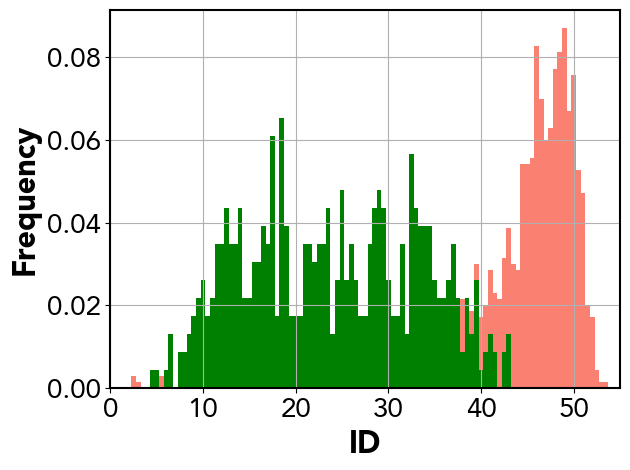

In [85]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d40_el_all[:-1], hist_d40_el_all, width=np.diff(bin_edges_d40_el_all), color="salmon")
plt.bar(bin_edges_d40_el_g[:-1], hist_d40_el_g, width=np.diff(bin_edges_d40_el_g),color="green")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(0,55)
ax.grid()
plt.savefig(f"{figures_dir}/IDdistribution_d40_el_all_good.pdf")
plt.show()

In [86]:
id_kde_d40_el, log_den_d40_el = id_kernel_density(ids_d40_el_good, bandwidth=0.5,verbose=True)
print(f"ID kde = {id_kde_d40_el:.2f}")

ID kde = 17.81


In [87]:
id_kde_d40_el_all, log_den_d40_el_all = id_kernel_density(ids_flat_d40_el, bandwidth=0.5,verbose=True)
print(f"ID kde = {id_kde_d40_el_all:.2f}")

ID kde = 48.82


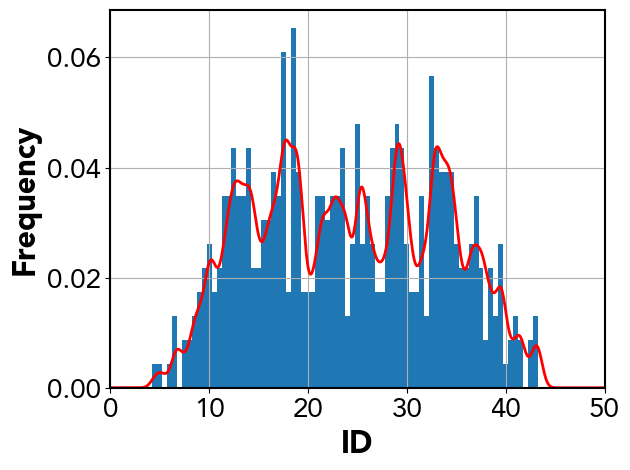

In [88]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_d40_el_g[:-1], hist_d40_el_g, width=np.diff(bin_edges_d40_el_g))
ax.plot(log_den_d40_el[0], np.exp(log_den_d40_el[1]), color="r")
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_xlim(0,50)
ax.grid()
plt.show()

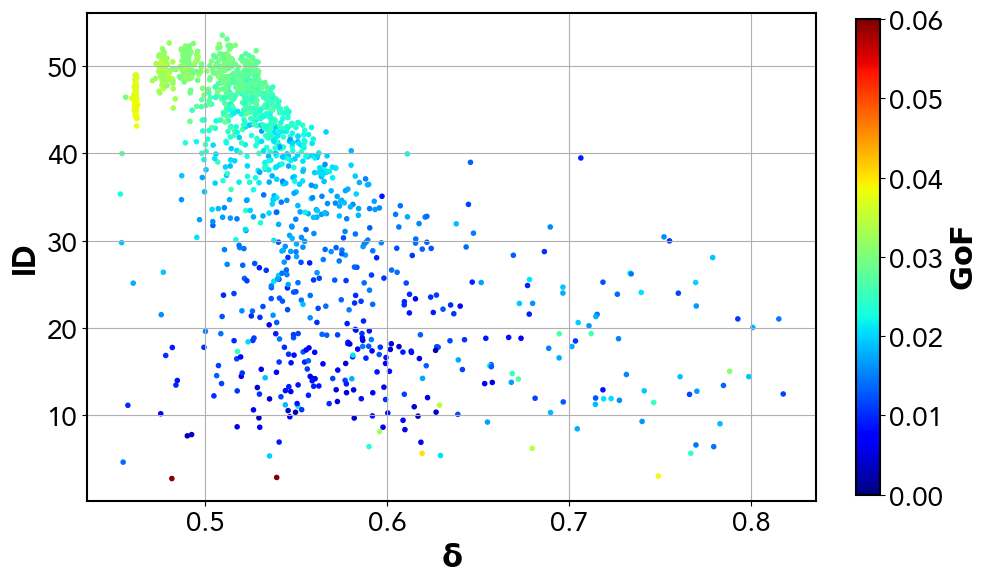

In [89]:
fig, ax = plt.subplots(figsize=(10,6),tight_layout=True)
AA = ax.scatter(deltas_flat_d40_el, ids_flat_d40_el, c=gof_flat_d40_el,vmin=0,vmax=0.06, cmap="jet", s=9)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_xlabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.show()

## All dimensions 

In [90]:
def compute_lfci(deltas, ids, gof, neighborhoods, gof_thr=0.02, delta_thr=3, check=False):
    deltas_flat = deltas.flatten()
    ids_flat = ids.flatten()
    k_flat = neighborhoods.flatten()
    gof_flat = gof.flatten()
    cond = (gof_flat<gof_thr)&(deltas_flat<delta_thr)
    idx_good = np.where(cond)
    idx_bad = np.where(~cond)
    k_good = k_flat[idx_good]
    ids_good = ids_flat[idx_good]
    k_bad = k_flat[idx_bad]
    ids_bad = ids_flat[idx_bad]
    id_kde_log_den = id_kernel_density(ids_good, bandwidth=0.3,verbose=check)
    if check:
        id_kde = id_kde_log_den[0]
        log_den = id_kde_log_den[1]
        hist_g, bin_edges_g = np.histogram(ids_good,range=(0,100), bins=200,density=True)
        return id_kde, log_den, hist_g, bin_edges_g
    else:
        return id_kde_log_den

In [91]:
def compute_lfci_dirt(deltas, ids, gof, neighborhoods, check=False):
    deltas_flat = deltas.flatten()
    ids_flat = ids.flatten()
    k_flat = neighborhoods.flatten()
    gof_flat = gof.flatten()
    ids_clean = ids_flat[~np.isnan(ids_flat)]
    deltas_clean = deltas_flat[~np.isnan(ids_flat)]
    k_clean = k_flat[~np.isnan(ids_flat)]
    id_kde_log_den = id_kernel_density(ids_clean, bandwidth=0.3,verbose=check)
    if check:
        id_kde = id_kde_log_den[0]
        log_den = id_kde_log_den[1]
        hist_g, bin_edges_g = np.histogram(ids_good,range=(0,100), bins=200,density=True)
        return id_kde, log_den, hist_g, bin_edges_g
    else:
        return id_kde_log_den

In [92]:
dimensions = [3, 6,10, 20, 40]

### Linear embedding

ID kde = 2.70, true dim = 3


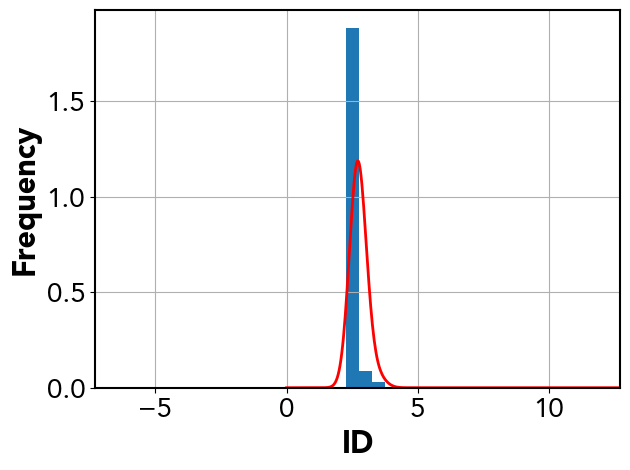

ID kde = 5.40, true dim = 6


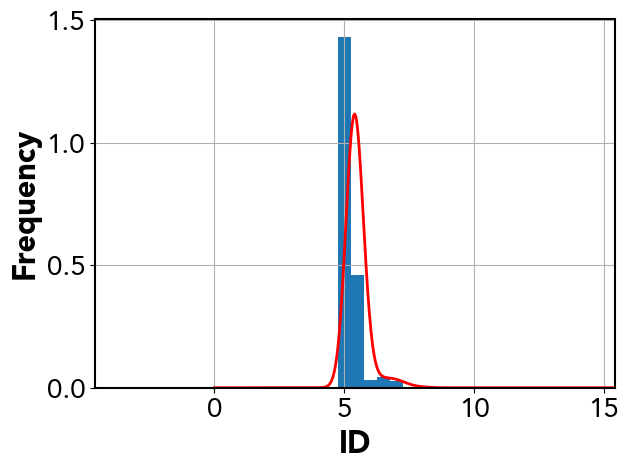

ID kde = 8.84, true dim = 10


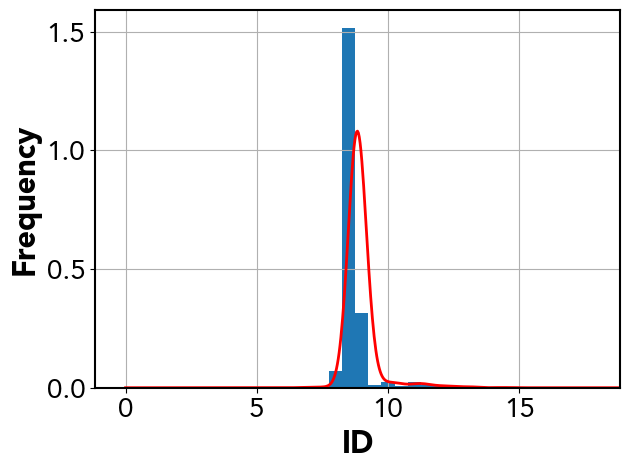

ID kde = 16.77, true dim = 20


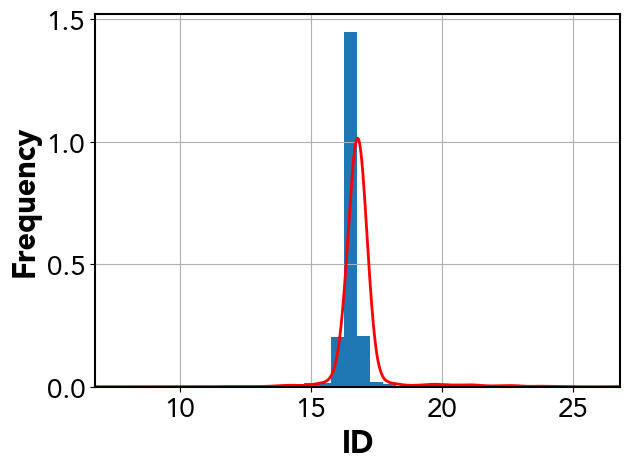

ID kde = 28.94, true dim = 40


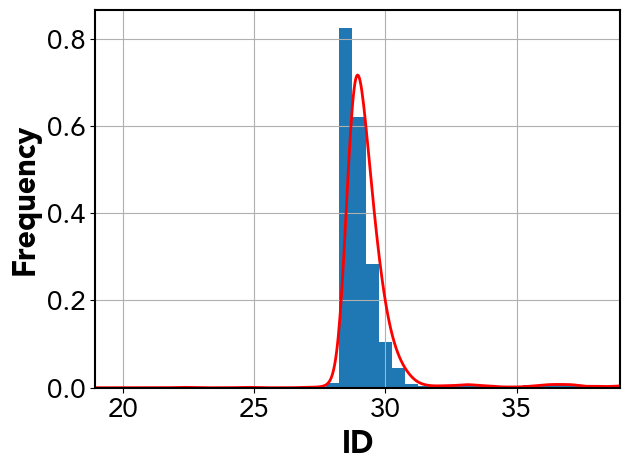

In [93]:
ID_linear = np.zeros((len(dimensions),))
ID_linear_dirt = np.zeros((len(dimensions),))
for i, dim in enumerate(dimensions):
    file_name = f"lfci_{dim}d_{embedding_lin}.h5"
    with h5py.File(f"{fci_folder}/{file_name}","r") as f:
        deltas_dim_ll = f["deltas"][:]
        ids_dim_ll = f["local_ids"][:][:,:,1]
        gof_dim_ll = f["local_ids"][:][:,:,2]
        k_dim_ll = f["local_ids"][:][:,:,0]

    id_kde, log_den, hist_g, bin_edges_g = compute_lfci(deltas_dim_ll, ids_dim_ll, gof_dim_ll, k_dim_ll, check=True)
    id_kde_dirt = compute_lfci_dirt(deltas_dim_ll, ids_dim_ll, gof_dim_ll, k_dim_ll)
    ID_linear[i] = id_kde
    ID_linear_dirt[i] = id_kde_dirt
    print(f"ID kde = {ID_linear[i]:.2f}, true dim = {dim}")
    fig, ax = plt.subplots(tight_layout=True)
    plt.bar(bin_edges_g[:-1], hist_g, width=np.diff(bin_edges_g))
    ax.plot(log_den[0], np.exp(log_den[1]), color="r")
    ax.set_xlabel("ID", fontweight="bold")
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_xlim(id_kde-10,id_kde+10)
    ax.grid()
    plt.show()

### Exponential embedding

ID kde = 2.80,ID kde dirt = 2.13, true dim = 3


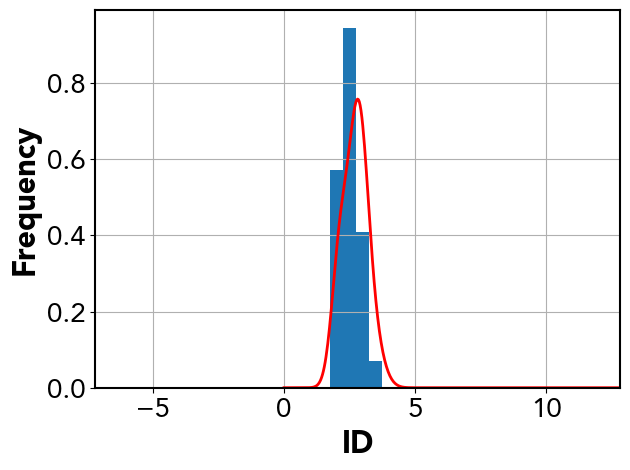

ID kde = 5.74,ID kde dirt = 5.74, true dim = 6


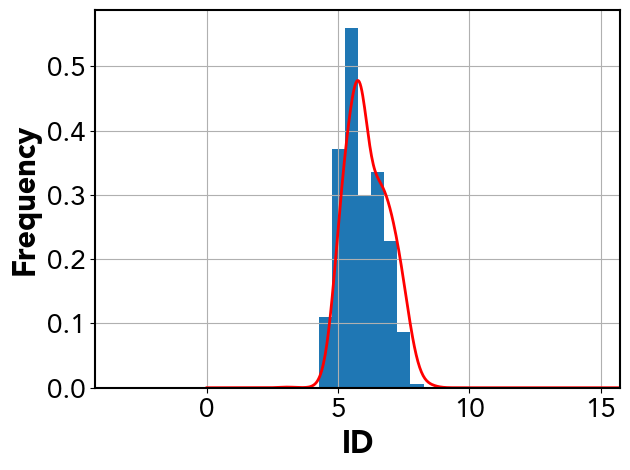

ID kde = 11.57,ID kde dirt = 11.27, true dim = 10


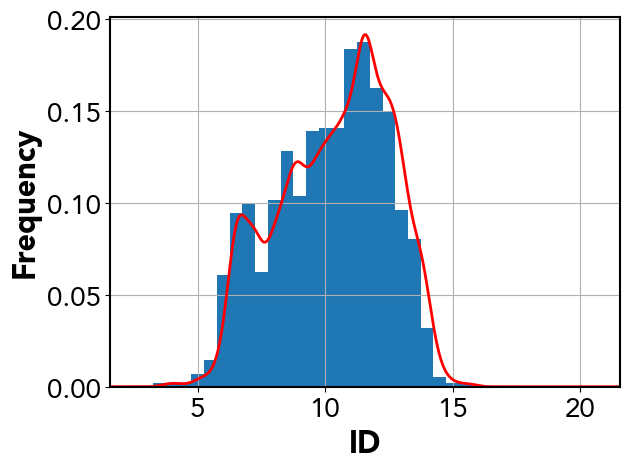

ID kde = 17.47,ID kde dirt = 23.14, true dim = 20


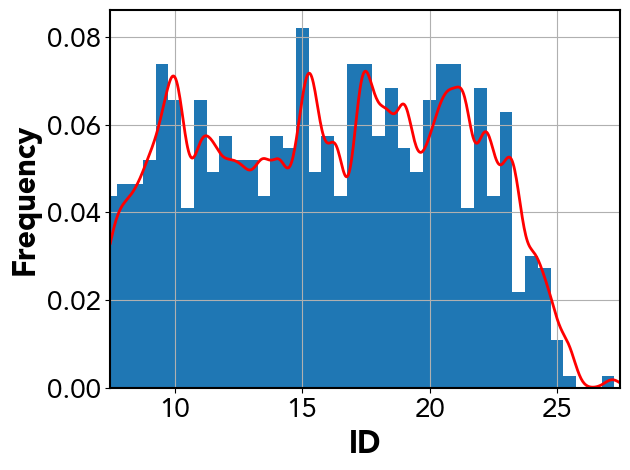

ID kde = 17.71,ID kde dirt = 48.62, true dim = 40


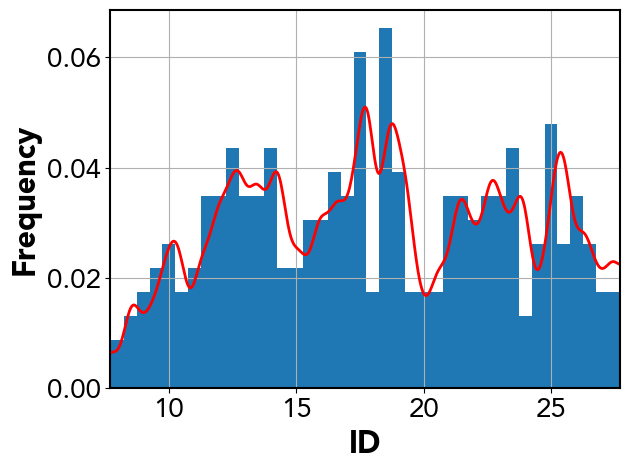

In [94]:
ID_exponential = np.zeros((len(dimensions),))
ID_exponential_dirt = np.zeros((len(dimensions),))
for i, dim in enumerate(dimensions):
    file_name = f"lfci_{dim}d_{embedding_exp}.h5"
    with h5py.File(f"{fci_folder}/{file_name}","r") as f:
        deltas_dim_el = f["deltas"][:]
        ids_dim_el = f["local_ids"][:][:,:,1]
        gof_dim_el = f["local_ids"][:][:,:,2]
        k_dim_el = f["local_ids"][:][:,:,0]
    id_kde, log_den, hist_g, bin_edges_g = compute_lfci(deltas_dim_el, ids_dim_el, gof_dim_el, k_dim_el,check=True)
    id_kde_dirt = compute_lfci_dirt(deltas_dim_el, ids_dim_el, gof_dim_el, k_dim_el)
    ID_exponential[i] = id_kde
    ID_exponential_dirt[i] = id_kde_dirt
    print(f"ID kde = {ID_exponential[i]:.2f},ID kde dirt = {ID_exponential_dirt[i]:.2f}, true dim = {dim}")
    fig, ax = plt.subplots(tight_layout=True)
    plt.bar(bin_edges_g[:-1], hist_g, width=np.diff(bin_edges_g))
    ax.plot(log_den[0], np.exp(log_den[1]), color="r")
    ax.set_xlabel("ID", fontweight="bold")
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_xlim(id_kde-10,id_kde+10)
    ax.grid()
    plt.show()

### Results

In [95]:
light_gray = "#BAB6B6"
medium_light_gray = "#9d9999"
medium_gray = "#817d7d"
dark_gray = "#4b4949"
viridis_blue = "#443983"

load data

In [96]:
diagonal = [[2, 5, 10, 20, 30, 40, 45], [2, 5, 10, 20, 30, 40, 45]]
true_dims = [3, 6, 10, 20, 40]

In [97]:
with h5py.File("Manuscript_Data_and_Code/fig4_data/analysis_effect_of_changing_true_d.h5", "r") as f: 
    PAs_exp_10_min = f['PAs_exp_10_min'][:]
    PAs_lin_10_min = f['PAs_lin_10_min'][:]
    TWONNs_exp_10_min = f['TWONNs_exp_10_min'][:]
    TWONNs_lin_10_min = f['TWONNs_lin_10_min'][:]
    MLEs_exp_10_min = f["MLEs_exp_10_min"][:]
    MLEs_lin_10_min = f["MLEs_lin_10_min"][:]

In [98]:
mean_PAs_lin = PAs_lin_10_min.mean(axis=1)
mean_TWONNs_lin = TWONNs_lin_10_min.mean(axis=1)
mean_MLEs_lin = MLEs_lin_10_min.mean(axis=1)
mean_PAs_exp = PAs_exp_10_min.mean(axis=1)
mean_TWONNs_exp = TWONNs_exp_10_min.mean(axis=1)
mean_MLEs_exp = MLEs_exp_10_min.mean(axis=1)

In [99]:
print("Linear embedding")
print("dim\tPA\ttwo NN\tMLE\tlFCI")
for i, dim in enumerate(true_dims):
    print(f"{dim}\t{mean_PAs_lin[i]:.2f}\t{mean_TWONNs_lin[i]:.2f}\t{mean_MLEs_lin[i]:.2f}\t{ID_linear[i]:.2f}")

Linear embedding
dim	PA	two NN	MLE	lFCI
3	3.00	3.04	2.99	2.70
6	6.00	5.94	5.88	5.40
10	10.00	8.82	8.77	8.84
20	20.00	9.70	10.40	16.77
40	29.33	5.66	6.54	28.94


In [100]:
print("Exponential embedding")
print("dim\tPA\ttwo NN\tMLE\tlFCI\tlFCI*")
for i, dim in enumerate(true_dims):
    print(f"{dim}\t{mean_PAs_exp[i]:.2f}\t{mean_TWONNs_exp[i]:.2f}\t{mean_MLEs_exp[i]:.2f}\t{ID_exponential[i]:.2f}\t{ID_exponential_dirt[i]:.2f}")

Exponential embedding
dim	PA	two NN	MLE	lFCI	lFCI*
3	3.00	2.98	3.02	2.80	2.13
6	10.67	6.10	6.04	5.74	5.74
10	23.67	8.65	8.69	11.57	11.27
20	26.00	11.58	11.52	17.47	23.14
40	29.33	13.20	13.24	17.71	48.62


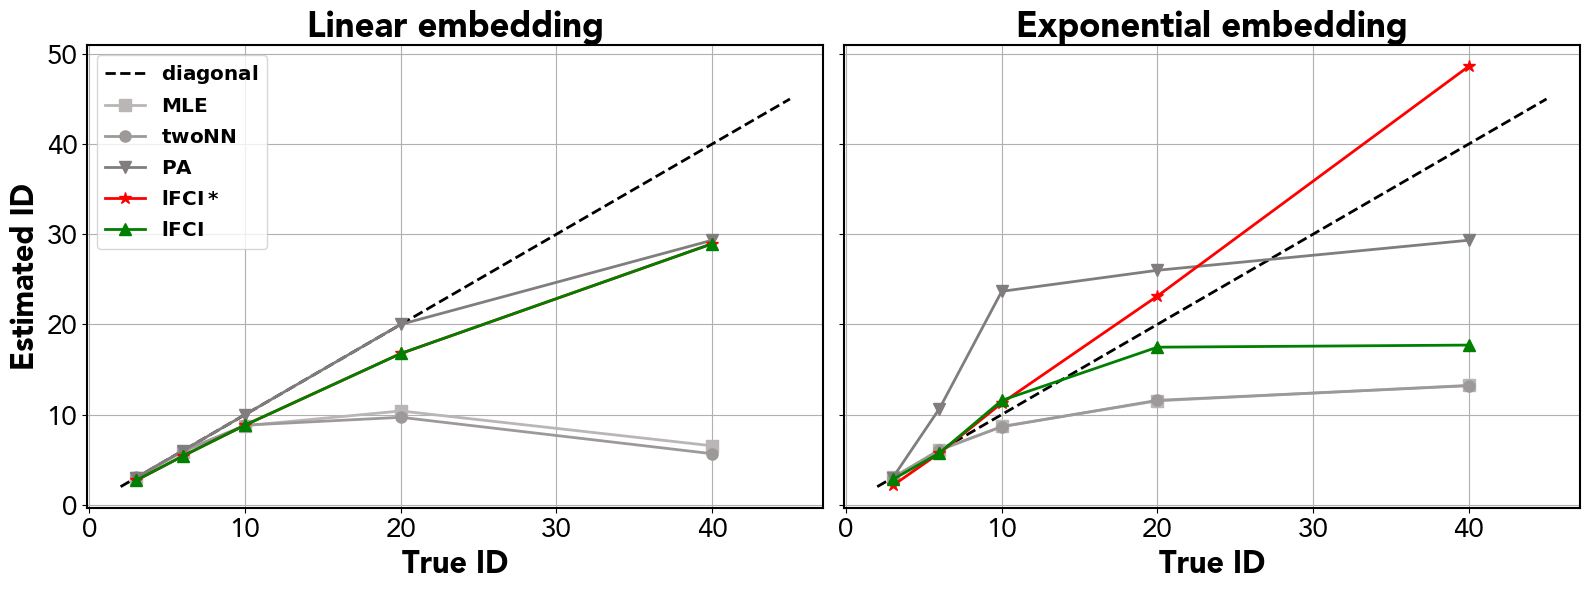

In [101]:
fig4, ax4 = plt.subplots(1, 2,figsize=(16,6),sharex=True,sharey=True,tight_layout=True)
ax4[0].plot(diagonal[0], diagonal[1], linestyle="--", label=r"$\mathbf{diagonal}$", color="black")
ax4[0].plot(true_dims, MLEs_lin_10_min.mean(axis=1), marker="s", label=r"$\mathbf{MLE}$", color=light_gray)
ax4[0].plot(true_dims, TWONNs_lin_10_min.mean(axis=1), marker="o", label=r"$\mathbf{two NN}$", color=medium_light_gray)
ax4[0].plot(true_dims, PAs_lin_10_min.mean(axis=1), marker="v", label=r"$\mathbf{PA}$", color=medium_gray)
ax4[0].plot(true_dims, ID_linear_dirt, marker="*", ms = 9, label=r"$\mathbf{lFCI*}$", color="red")
ax4[0].plot(true_dims, ID_linear, marker="^", ms = 9, label=r"$\mathbf{lFCI}$", color="green")
ax4[0].set_title("Linear embedding", fontsize = "25",fontweight="bold")
ax4[0].set_ylabel("Estimated ID", fontweight="bold")
ax4[0].set_xlabel("True ID", fontweight="bold")
ax4[0].legend(fontsize="x-large")
ax4[0].grid(True)

ax4[1].plot(diagonal[0], diagonal[1], linestyle="--", label="diagonal", color="black")
ax4[1].plot(true_dims, MLEs_exp_10_min.mean(axis=1), marker="s", label="MLE", color=light_gray)
ax4[1].plot(true_dims, TWONNs_exp_10_min.mean(axis=1), marker="o", label="two NN", color=medium_light_gray)
ax4[1].plot(true_dims, PAs_exp_10_min.mean(axis=1), marker="v", label="PA", color=medium_gray)
ax4[1].plot(true_dims, ID_exponential_dirt, marker="*", ms = 9, label=r"$\mathbf{lFCI*}$", color="red")
ax4[1].plot(true_dims, ID_exponential, marker="^", ms = 9, label=r"$\mathbf{lFCI}$", color="green")
ax4[1].set_title("Exponential embedding", fontsize = "25",fontweight="bold")
ax4[1].set_xlabel("True ID", fontweight="bold")
ax4[1].grid(True)


plt.savefig("lin_vs_exp_lfci.pdf")
plt.show()

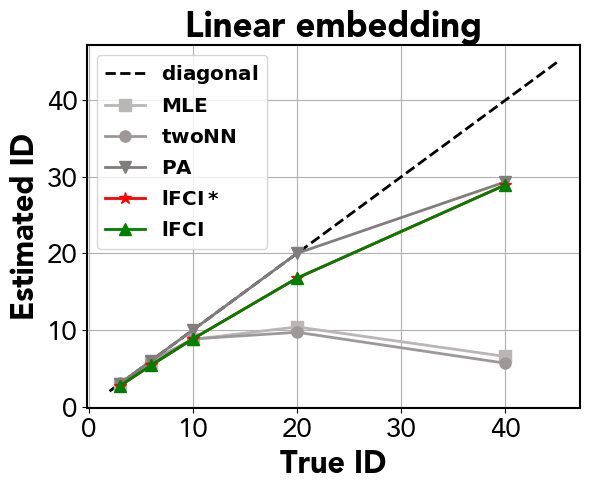

In [102]:
fig4, ax4 = plt.subplots(figsize=(6,5),tight_layout=True)
ax4.plot(diagonal[0], diagonal[1], linestyle="--", label=r"$\mathbf{diagonal}$", color="black")
ax4.plot(true_dims, MLEs_lin_10_min.mean(axis=1), marker="s", label=r"$\mathbf{MLE}$", color=light_gray)
ax4.plot(true_dims, TWONNs_lin_10_min.mean(axis=1), marker="o", label=r"$\mathbf{two NN}$", color=medium_light_gray)
ax4.plot(true_dims, PAs_lin_10_min.mean(axis=1), marker="v", label=r"$\mathbf{PA}$", color=medium_gray)
ax4.plot(true_dims, ID_linear_dirt, marker="*", ms = 9, label=r"$\mathbf{lFCI*}$", color="red")
ax4.plot(true_dims, ID_linear, marker="^", ms = 9, label=r"$\mathbf{lFCI}$", color="green")
ax4.set_title("Linear embedding", fontsize = "25",fontweight="bold")
ax4.set_ylabel("Estimated ID", fontweight="bold")
ax4.set_xlabel("True ID", fontweight="bold")
ax4.legend(fontsize="x-large")
ax4.grid(True)

plt.savefig("lFCI_lin_embedding_trueID.pdf")
plt.show()

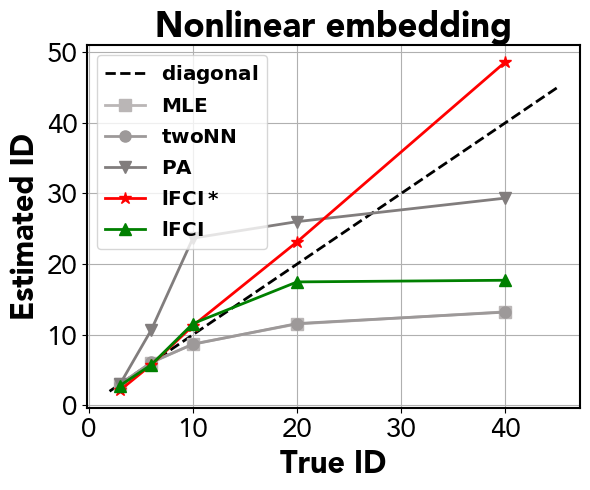

In [103]:
fig4, ax4 = plt.subplots(figsize=(6,5),tight_layout=True)
ax4.plot(diagonal[0], diagonal[1], linestyle="--", label=r"$\mathbf{diagonal}$", color="black")
ax4.plot(true_dims, MLEs_exp_10_min.mean(axis=1), marker="s", label=r"$\mathbf{MLE}$", color=light_gray)
ax4.plot(true_dims, TWONNs_exp_10_min.mean(axis=1), marker="o", label=r"$\mathbf{two NN}$", color=medium_light_gray)
ax4.plot(true_dims, PAs_exp_10_min.mean(axis=1), marker="v", label=r"$\mathbf{PA}$", color=medium_gray)
ax4.plot(true_dims, ID_exponential_dirt, marker="*", ms = 9, label=r"$\mathbf{lFCI*}$", color="red")
ax4.plot(true_dims, ID_exponential, marker="^", ms = 9, label=r"$\mathbf{lFCI}$", color="green")
ax4.set_title("Nonlinear embedding", fontsize = "25",fontweight="bold")
ax4.set_ylabel("Estimated ID", fontweight="bold")
ax4.set_xlabel("True ID", fontweight="bold")
ax4.legend(fontsize="x-large")
ax4.grid(True)

plt.savefig("lFCI_exp_embedding_trueID.pdf")
plt.show()